In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#Perform basic dimension check

#Read in full toxicity dataset
#Depending on which set of features you want to test (toxicity_data.csv is the full set)

#data = pd.read_csv('toxicity_data_13.csv')
data = pd.read_csv('toxicity_data.csv')
#data = pd.read_csv('toxicity_filtered.csv')
#data = pd.read_csv('toxicity_newfilter_rfe.csv')
print(data.columns)
features = data.columns

#Output dimensions of the data
print("Dimensions of toxicity data:")
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])

Index(['MATS3v', 'nHBint10', 'MATS3s', 'MATS3p', 'nHBDon_Lipinski',
       'minHBint8', 'MATS3e', 'MATS3c', 'minHBint2', 'MATS3m',
       ...
       'WTPT-4', 'WTPT-5', 'ETA_EtaP_L', 'ETA_EtaP_F', 'ETA_EtaP_B', 'nT5Ring',
       'SHdNH', 'ETA_dEpsilon_C', 'MDEO-22', 'Class'],
      dtype='object', length=1204)
Dimensions of toxicity data:
Number of rows: 171
Number of columns: 1204


In [3]:
def sigmoid(z):
    """
    sigmoid() is the simple mathematical function mapping real numbers to probabilities between 0 and 1
    """
    return 1/(1+np.exp(-z))

In [84]:
def logistic_regression(X_input, y_output, learning_rate=0.001, number_iters=1000):
    """
    logistic_regression() is the main function that is used to perform binary classification given predictor
    variables X, output variables y, and parameters learning_rate and number_of_iterations. The function uses 
    gradient descent and the sigmoid function to continually update weights and biases of predictor variables 
    to minimize the loss function. 
    Input: numpy array
    Output: optimized_weights (numpy array), bias (float)
    """
    
    #Get the number of samples (rows) and features (columns)
    number_samples, number_features = X_input.shape

    #Initialize parameters, weights/bias
    optimized_weights = np.zeros(number_features)
    optimized_bias = 0

    #Perform gradient descent over number of iterations
    for _ in range(number_iters):
        #Compute linear combination of weights and features considering bias
        linear_combination = np.dot(X_input, optimized_weights) + optimized_bias
        
        #Apply sigmoid function for probabilities over range
        predicted_probabilities = sigmoid(linear_combination)

        #Calculate gradients
        deltaweight = (1 / number_samples) * np.dot(X_input.T, (predicted_probabilities - y_output))
        deltabias = (1 / number_samples) * np.sum(predicted_probabilities - y_output)              

        #Update weights and bias using gradients according to learning rate
        optimized_weights -= learning_rate * deltaweight
        optimized_bias -= learning_rate * deltabias

    return optimized_weights, optimized_bias

def logistic_regression_predict(X_input, optimized_weights, optimized_bias):
    """
    logistic_regression_predict() takes in a set of predictor variables X and their corresponding weights and
    biases. It performs predictions on the variables according to their biases and the logistic regression model.
    It returns a set of binary class labels predicted by the variables. 
    """
    #Compute the linear combination of weights and features, plus bias
    linear_combination = np.dot(X_input, optimized_weights) + optimized_bias
    
    #Apply sigmoid function to obtain predicted probabilities
    predicted_probabilities = sigmoid(linear_combination)
    
    #Classify based on threshold (0.5)
    y_predicted_classes = [1 if prob > 0.5 else 0 for prob in predicted_probabilities]

    return np.array(y_predicted_classes)

def select_best_feature(X_input, y_output, selected_features):
    """
    select_best_feature() takes in a set of predictor variables X_input and a set of outcomes y_output, and 
    a set of existing selected features based on logistic regression feature importances. It identifies the index
    of the most important remaining feature to be added to the set of selected features.
    """
    #Identify remaining features not yet selected
    remaining_features = [i for i in range(X_input.shape[1]) if i not in selected_features]
    
    #Initialize variables to keep track of the best feature and its score
    best_score = -np.inf
    best_feature_index = None

    #Iterate over remaining features to find the best one
    for feature_index in remaining_features:
        #Combine selected features with the current feature
        features_subset = selected_features + [feature_index]
        X_subset = X_input[:, features_subset]

        weights, bias = logistic_regression(X_subset, y_output)
        
        linear_combination = np.dot(X_subset, weights) + bias
        predicted_probabilities = sigmoid(linear_combination)
        
        score = compute_score(y_output, predicted_probabilities)
        if score > best_score:
            best_score = score
            best_feature_index = feature_index

    return best_feature_index

def compute_score(y_actual, y_pred):
    """
    compute_score() takes in a set of outcome predictions by our logistic regression model and the set of true known
    outcomes, and compares them to obtain the accuracy of the model at predicting outcomes.
    """
    number_outcomes = len(y_actual)
    accuracy = np.sum(y_actual == y_pred) / number_outcomes
    return accuracy

def standard_scaler(X):
    """
    standard_scaler() is a normalization function that preprocesses data for the logistic regression model.
    It normalizes each predictor variable x to have a mean of 0 and standard deviation of 1, and returns the 
    set of predictor variables sclaed_X.
    """
    #Calculate the mean of each feature
    means = X.mean(axis=0)
    
    #Calculate the standard deviation of each feature
    stds = X.std(axis=0)
    stds[stds==0]=1
    
    #Apply standard scaling to each feature
    scaled_X = (X - means) / stds
    
    return scaled_X


def train_test_split(X, y, test_size=0.3, random_state=None):
    """train_test_split() splits the dataset into training and testing sets based on a desired splitting size.
    """
    if random_state is not None:
        np.random.seed(random_state)

    #Shuffle indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    #Calculate the number of samples for the testing set
    num_test_samples = int(len(X) * test_size)

    #Split the shuffled indices into training and testing indices
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]

    #Split the dataset into training and testing sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test

In [39]:
#Define a set of test functions for the supporting functions above

def test_compute_score():
    """
    test_compute_score() runs the compute_score function for a set of sample predicted values to assess prediction accuracy
    """
    #Test cases
    y_true = np.array([0, 1, 0, 1, 1])
    y_pred = np.array([0, 1, 0, 0, 1])
    expected_output = 0.8

    #Run
    output = compute_score(y_true, y_pred)
    assert np.isclose(output, expected_output), f"Test failed: Expected {expected_output}, Got {output}"

    print("Compute score function test passed.")
    
def test_sigmoid():
    """
    test_sigmoid() runs the sigmoid function for a set of sample inputs to ensure the outputs are precise enough
    """
    test_inputs = [0, 1, -1, 10, -10]
    expected_outputs = [0.5, 0.73105858, 0.26894142, 0.9999546, 4.53978687e-05]
    for input_val, expected_output in zip(test_inputs, expected_outputs):
        output = sigmoid(input_val)
        assert np.isclose(output, expected_output), f"Test failed: Input {input_val}, Expected {expected_output}, Got {output}"

    print("Sigmoid function test passed.")
    
def test_standard_scaler():
    """
    test_standard_scaler() runs the standard_scaler function for a sample dataset to ensure it is performing the proper
    normalization. 
    """
    #Test dataset
    X = np.array([[1, 2], [3, 4], [5, 6]])

    expected_mean = np.mean(X, axis=0)
    expected_std = np.std(X, axis=0)

    #Apply our standard scaler
    standardized_X = standard_scaler(X)
    std_scaled_X = standardized_X.std(axis=0)
    
    #Check if the standardized dataset has mean 0 and standard deviation 1
    standardized_X_mean = np.mean(standardized_X, axis=0)
    standardized_X_std = np.std(standardized_X, axis=0)
    assert np.allclose(standardized_X_mean, np.zeros_like(standardized_X_mean)), "Mean of standardized dataset is not 0."
    assert np.allclose(standardized_X_std, np.ones_like(standardized_X_std)), "Standard deviation of standardized dataset is not 1."

    print("Standard scaler function test passed.")


test_sigmoid()
test_compute_score()
test_standard_scaler()

Sigmoid function test passed.
Compute score function test passed.
Standard scaler function test passed.


In [36]:
#Toxicity data has class variable (toxic vs nontoxic) as target variable
X = data.drop('Class', axis=1) 
y = data['Class']

#Print XPortion
print("Input features for logistic regression (X):")
X = X.to_numpy()
print(X)
print(type(X))
print()

#Print YPortion
print("Target variable for logistic regression:")
print(y.head())
print()

#Convert target variable numeric
#0 FOR NONTOXIC
#1 FOR TOXIC
y_numeric = [0 if label == 'NonToxic' else 1 for label in y]
#Convert to numpy array
y_numeric = np.array(y_numeric)

#Print YNumericPortion
#y_numeric represents our binary classifications of outcomes, where 0 is nontoxic and 1 is toxic
print("Target variable for logistic regression:")
print(y_numeric)
print(type(y_numeric))

Input features for logistic regression (X):
[[ 9.080e-02  0.000e+00  7.500e-03 ...  0.000e+00 -8.680e-02  0.000e+00]
 [ 2.130e-02  0.000e+00  1.144e-01 ...  0.000e+00 -8.100e-02  2.500e-01]
 [ 1.800e-03  0.000e+00 -1.560e-02 ...  0.000e+00 -1.004e-01  0.000e+00]
 ...
 [ 9.600e-03  2.000e+00 -1.846e-01 ...  0.000e+00 -9.270e-02  0.000e+00]
 [-7.360e-02  2.000e+00 -1.267e-01 ...  0.000e+00 -1.129e-01  0.000e+00]
 [-1.864e-01  0.000e+00 -2.000e-03 ...  0.000e+00 -1.915e-01  0.000e+00]]
<class 'numpy.ndarray'>

Target variable for logistic regression:
0    NonToxic
1    NonToxic
2    NonToxic
3    NonToxic
4    NonToxic
Name: Class, dtype: object

Target variable for logistic regression:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 

In [40]:
#Split the X and y_numeric into training and testing for future use
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2, random_state=42)

#Test train/test split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

#Normalize datasets using standard scaler function
X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

Shape of X_train: (137, 1203)
Shape of X_test: (34, 1203)
Shape of y_train: (137,)
Shape of y_test: (34,)


In [41]:
#XTrain
print(X_train)
#XTest
print(X_test)
#YTrain
print(y_train)
#YTest
print(y_test)

[[-0.02518237 -0.41299229 -1.04737752 ... -0.12160992 -1.1952994
  -0.256843  ]
 [-0.55479985 -0.41299229  0.4012476  ... -0.12160992  1.44374106
  -0.256843  ]
 [-1.17573068 -0.41299229 -0.70963177 ... -0.12160992 -0.42628504
  -0.256843  ]
 ...
 [ 1.98869224 -0.41299229 -0.54796201 ... -0.12160992  0.40709616
  -0.256843  ]
 [-0.69758073 -0.41299229 -0.37188603 ... -0.12160992 -0.06041037
  -0.256843  ]
 [-0.83040016 -0.41299229 -0.52875372 ... -0.12160992  0.43419798
  -0.256843  ]]
[[ 0.02692026  1.56501609 -0.58104678 ...  0.          1.04211063
  -0.31724765]
 [-0.17193716  3.61157559 -0.57226652 ...  0.          0.2646952
  -0.31724765]
 [ 0.12771101 -0.48154341  0.52380292 ...  0.          0.44851757
  -0.31724765]
 ...
 [-0.99596964 -0.48154341  0.09210668 ...  0.          1.30635529
  -0.31724765]
 [-0.26319365 -0.48154341  1.83352541 ...  0.          0.14214695
  -0.31724765]
 [-0.56965201 -0.48154341 -1.21761581 ...  0.          1.54379251
  -0.31724765]]
[1 1 0 0 0 1 1 1 1

Accuracy: 44.12%
Accuracy: 47.06%
Accuracy: 47.06%
Accuracy: 50.00%
Accuracy: 47.06%
Accuracy: 47.06%
Accuracy: 47.06%
Accuracy: 52.94%
Accuracy: 55.88%
Accuracy: 50.00%
Accuracy: 50.00%
Accuracy: 50.00%
Accuracy: 50.00%


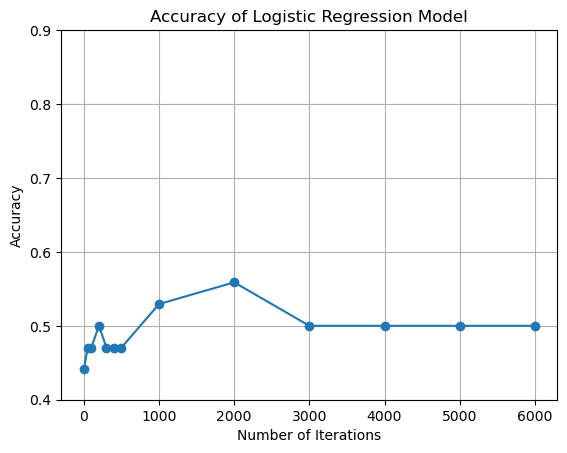

In [48]:
#Switch hyperparameters up
learning_rate = 0.1
num_iterations_list = [1, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000, 6000]

#Train the logistic regression model and evaluate accuracy for each number of iterations
accuracy_scores = []
for num_iterations in num_iterations_list:
    #Training step
    weights, bias = logistic_regression(X_train, y_train, learning_rate, num_iterations)
    
    #Make predictions on the test data
    y_pred = logistic_regression_predict(X_test, weights, bias)
    
    #Calculate accuracy
    acc = compute_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(acc* 100))
    accuracy_scores.append(acc)

#Plot accuracy over iterations
plt.plot(num_iterations_list, accuracy_scores, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy of Logistic Regression Model')
plt.grid(True)
plt.ylim(0.4,0.9)
plt.show()

In [51]:
#Evaluate coefficients
#Print the indices of the top 13 weighted features
print(weights)
print(np.argsort(weights)[-13:])
print(weights.shape)

#NCBI Selected 13
#MDEC23
#MATS2v
#ATSC8s
#VE3Dt
#CrippenMR
#SpMax7_Bhe
#SpMin1_Bhs
#C1SP2
#GATS8e
#GATS8s
#SpMax5_Bhv
#VE3_Dzi
#VPC-4

#Logistic regression found 1 
#GATS8s

[-0.00998268 -0.05520172 -0.07347867 ... -0.01245073  0.03697267
  0.50198887]
[ 257  539  645  708  643  155  271 1080  742   43  495  424  739]
(1203,)


In [65]:
def precision_score(y_true, y_pred):
    """
    precision_score() is a simple function that calculates the f1score for a given set of true and predicted y
    """
    true_positives = sum((true == 1 and pred == 1) for true, pred in zip(y_true, y_pred))
    predicted_positives = sum(y_pred)
    
    if predicted_positives == 0:
        return 0
    
    return true_positives / predicted_positives

def recall_score(y_true, y_pred):
    """
    recall_score() is a simple function that calculates the recall for a given set of true and predicted y
    """
    true_positives = sum((true == 1 and pred == 1) for true, pred in zip(y_true, y_pred))
    actual_positives = sum(y_true)
    
    if actual_positives == 0:
        return 0
    
    return true_positives / actual_positives

def f1_score(y_true, y_pred):
    """
    f1_score() is a simple function that calculates the f1score for a given set of true and predicted y
    """

    tp = sum((true == 1) and (pred == 1) for true, pred in zip(y_true, y_pred))
    fp = sum((true == 0) and (pred == 1) for true, pred in zip(y_true, y_pred))
    fn = sum((true == 1) and (pred == 0) for true, pred in zip(y_true, y_pred))
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    return f1

def recursive_feature_elimination(X, y, learning_rate, num_iterations, n_features_to_select):
    """
    recursive_feature_elimination() takes in a set of predictor and outcome variables X and y, as well as parameters to 
    dictate the learning_rate and number of iterations, and number of features to select. It iteratively runs our
    logistic regression model using the provided parameters and selects the top n set of features deemed important by
    the model. 
    """
    remaining_features = list(range(X.shape[1]))
    selected_features = []
    test_accuracies = []
    test_metrics = []
    
    while len(selected_features) < n_features_to_select:
        scores = []
        for feature in remaining_features:
            features_subset = selected_features + [feature]
            X_subset = X[:, features_subset]
            
            #Training
            weights, bias = logistic_regression(X_subset, y, learning_rate, num_iterations)
            
            #Prediction
            y_pred = logistic_regression_predict(X_subset, weights, bias)
            
            #Accuracy
            acc = compute_score(y, y_pred)
            scores.append((acc, feature))
            precision = precision_score(y, y_pred)
            recall = recall_score(y, y_pred)
            f1 = f1_score(y, y_pred)
        
        accuracy_scores = [score[0] for score in scores]
        mean_accuracy = np.mean(accuracy_scores)
        
        scores.sort(reverse=True)
        best_acc, best_feature = scores.pop(0)
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        test_accuracies.append(mean_accuracy)
        print(f'Selected Features: {selected_features}, Accuracy: {best_acc}')
    
    return selected_features, test_accuracies


In [66]:
selected_features, test_accuracies = recursive_feature_elimination(X_train, y_train, 0.01, 10, 13)

Selected Features: [1184], Accuracy: 0.6861313868613139
Selected Features: [1184, 1040], Accuracy: 0.7153284671532847
Selected Features: [1184, 1040, 918], Accuracy: 0.7299270072992701
Selected Features: [1184, 1040, 918, 884], Accuracy: 0.7445255474452555
Selected Features: [1184, 1040, 918, 884, 1176], Accuracy: 0.7518248175182481
Selected Features: [1184, 1040, 918, 884, 1176, 934], Accuracy: 0.7591240875912408
Selected Features: [1184, 1040, 918, 884, 1176, 934, 920], Accuracy: 0.7664233576642335
Selected Features: [1184, 1040, 918, 884, 1176, 934, 920, 1192], Accuracy: 0.7737226277372263
Selected Features: [1184, 1040, 918, 884, 1176, 934, 920, 1192, 624], Accuracy: 0.781021897810219
Selected Features: [1184, 1040, 918, 884, 1176, 934, 920, 1192, 624, 495], Accuracy: 0.7883211678832117
Selected Features: [1184, 1040, 918, 884, 1176, 934, 920, 1192, 624, 495, 1181], Accuracy: 0.7956204379562044
Selected Features: [1184, 1040, 918, 884, 1176, 934, 920, 1192, 624, 495, 1181, 1198], A

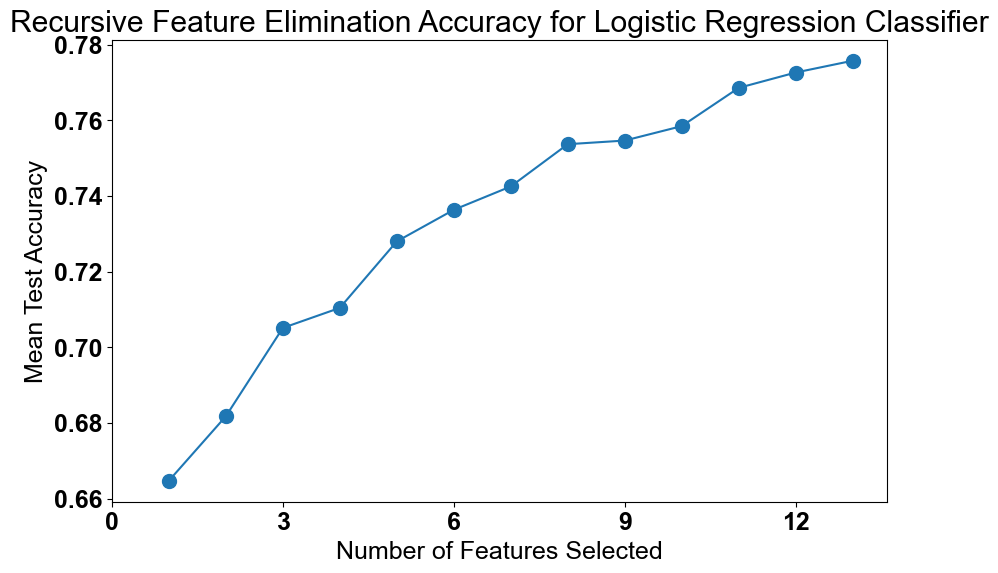

In [67]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 18
mpl.rcParams['font.weight'] = 'bold'

#Plot the mean test accuracy vs. number of features selected
plt.figure(figsize=(10, 6))

#Plot data for the first 20 indices
plt.plot(range(1, 14), test_accuracies[:13], marker='o', linestyle='-', markersize=10)

#Set x and y labels
plt.xlabel('Number of Features Selected')
plt.ylabel('Mean Test Accuracy')

#Set x-axis ticks to display only integers
plt.xticks(range(0, 13, 3))

#Set title
plt.title('Recursive Feature Elimination Accuracy for Logistic Regression Classifier')

#Show plot
plt.show()

In [257]:
print(X_train.shape)

(136, 942)


In [72]:
X = data.drop(columns=['Class'])
#First RFE selected features
#true_indices = np.array([608, 604, 840, 736, 793, 423, 933, 642, 261, 936, 934, 929, 463])
#true_indices = np.array([[925, 248, 125, 618, 935, 106, 632, 696, 940, 931, 906, 916, 910]])
true_indices = np.array([1184, 334, 164, 884, 1168, 657, 1200, 922, 80, 1194, 1192, 1190, 1185])
#true_indices = np.array([1042, 645, 142, 20, 587, 288, 787, 882, 12, 399, 1168, 106, 309])

#Get the names of selected features
selected_features = X.columns[true_indices]
print("The selected RFE features from the full dataset are:", selected_features)

#Sklearn found:
#Index(['SpMax4_Bhm', 'MATS7v', 'maxssNH', 'MATS6s', 'ATSC2e', 'minsF',
#      'MDEN-22', 'VR1_Dt', 'ATSC5e', 'ATSC5m', 'AATSC6e', 'SsF',
#      'SpMax5_Bhm'],

The selected RFE features from the full dataset are: Index(['AATSC1v', 'MATS7v', 'SpMax4_Bhe', 'khs.tsC', 'GATS5c', 'nHBint3',
       'SHdNH', 'SHBint7', 'nFRing', 'WTPT-4', 'WTPT-2', 'ETA_Eta', 'AATSC1m'],
      dtype='object')


In [81]:
#Test different featuresets found by logreg and RTE

data = pd.read_csv('toxicity_data.csv')
#Extract the features and target variable
#RFE determined features stored in features_set1
#features_set1 = ['AATSC1v', 'MATS7v', 'SpMax4_Bhe', 'khs.tsC', 'GATS5c', 'nHBint3', 'SHdNH', 'SHBint7', 'nFRing', 'WTPT-4', 'WTPT-2', 'ETA_Eta', 'AATSC1m']
#features_set1 = ['GATS7v', 'AATS1i', 'SpMax2_Bhe', 'ASP-4', 'VR3_Dzv', 'SpMin2_Bhm','WTPT-2', 'AATS0p', 'ATSC3v', 'WTPT-5', 'WTPT-3', 'LipoaffinityIndex','SpMin5_Bhv']
features_set1 = ['AATSC1v', 'MATS7v', 'SpMax4_Bhe', 'AATSC4i', 'WTPT-4', 'AATSC3p', 'ATSC6c', 'Mse', 'nT5Ring', 'ETA_Eta', 'VPC-5', 'VR1_Dzv', 'Mpe']

#LogReg selected features stored in features_set2
features_set2 = ['WTPT-1', 'JGI9', 'JGI4', 'khs.dssC', 'GATS8s', 'nAtomLAC', 'BCUTw-1l', 'JGI7', 'minaasC', 'EE_Dt', 'minssCH2', 'WTPT-2', 'nG']

#NCBIPaper selected features stored in features_set3
features_set3 = ['MDEC-23', 'MATS2v', 'ATSC8s','VE3_Dt','CrippenMR','SpMax7_Bhe','SpMin1_Bhs','C1SP2','GATS8e','GATS8s','SpMax5_Bhv','VE3_Dzi','VPC-4']

#XGBoost selected features stored in features_set4
features_set4 = ['MATS3v', 'nHBint10', 'MATS3s','MATS3p','nHBDon_Lipinski','minHBint8','MATS3e','MATS3c','minHBint2','MATS3m','minHBint6','minHBint7','minHBint4']

#Toxicity data has class variable (toxic vs nontoxic) as target variable
X = data.drop('Class', axis=1) 
y = data['Class']

X = X.to_numpy()

#Convert target variable numeric
#0 FOR NONTOXIC
#1 FOR TOXIC
y_numeric = [0 if label == 'NonToxic' else 1 for label in y]
#Convert to numpy array
y_numeric = np.array(y_numeric)

X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.3, random_state=42)
#Test train/test split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

#Normalize TEST using custom standard scaler function
X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

Shape of X_train: (120, 1203)
Shape of X_test: (51, 1203)
Shape of y_train: (120,)
Shape of y_test: (51,)


In [97]:
#Set hyperparameters for logistic regression
learning_rate = 0.3
num_iterations = 1000

#Initialize lists to store results
weights_list = []
bias_list = []
y_pred_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

#Define feature sets
feature_sets = [features_set1, features_set2, features_set3, features_set4]  # Add more sets as needed

#Train logistic regression models for each feature set
for features_set in feature_sets:
    #Train logistic regression model
    weights, bias = logistic_regression(X_train[:, [list(data.columns).index(feature) for feature in features_set]], y_train, learning_rate, num_iterations)
    
    #Make predictions on the test set
    y_pred = logistic_regression_predict(X_test[:, [list(data.columns).index(feature) for feature in features_set]], weights, bias)
    
    #Calculate accuracy metrics
    accuracy = compute_score(y_test, y_pred)
    precision, recall, f1 = precision_recall_f1(y_test, y_pred)
    
    #Store results
    weights_list.append(weights)
    bias_list.append(bias)
    y_pred_list.append(y_pred)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

#Print the evaluated results for each feature set
for i, features_set in enumerate(feature_sets):
    print("Feature Set:", features_set)
    print("Accuracy:", accuracy_list[i])
    print("Precision:", precision_list[i])
    print("Recall:", recall_list[i])
    print("F1 Score:", f1_list[i])
    print()

RESULTS 3 7 13
[1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0]
RESULTS 5 5 11
[1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0] [1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
RESULTS 1 2 15
[1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
RESULTS 2 8 14
[1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0
 0 0 1 1 1 1 0 0 0 0 0 0 0 0] [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 0 1 0 1 1 0 0]
Feature Set: ['AATSC1v', 'MATS7v', 'SpMax4_Bhe', 'AATSC4i', 'WTPT-4', 'AATSC3p', 'ATSC6c', 'Mse', 'n

In [70]:
data = pd.read_csv('toxicity_data.csv')
#toxicitiy_filtered
#selected_columns = ['GATS7v', 'AATS1i', 'SpMax2_Bhe', 'ASP-4', 'VR3_Dzv', 'SpMin2_Bhm','WTPT-2', 'AATS0p', 'ATSC3v', 'WTPT-5', 'WTPT-3', 'LipoaffinityIndex','SpMin5_Bhv']
selected_columns = ['AATSC7p', 'ATSC1v', 'AATSC2c', 'hmax', 'ndS', 'WTPT-3', 'ATS6s','AATSC0p', 'nT5Ring', 'maxHdCH2', 'ndCH2', 'SdCH2', 'TIC0', 'Class']
new_data = data[selected_columns].copy()

#Save reduced features to csv
new_data.to_csv('toxicity_newfilter_rfe.csv', index=False)

In [72]:
y

0      NonToxic
1      NonToxic
2      NonToxic
3      NonToxic
4      NonToxic
         ...   
166    NonToxic
167    NonToxic
168    NonToxic
169       Toxic
170       Toxic
Name: Class, Length: 171, dtype: object